In [440]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols

# Config
plt.rcParams['figure.dpi'] = 100

In [306]:
df = pd.read_csv('msc_collated_data_20230709.csv')
df.columns

Index(['Unnamed: 0', 'section', 'task_section', 'task', 'trial_id', 'cue_dir',
       'valid_cue', 'key_resp.keys', 'key_resp.rt', 'correct_response',
       'median_left_eye_x', 'mean_left_eye_x', 'participant_number',
       'session_number', 'session_type', 'no_bad_eye_indicies', 'median_aai',
       'mean_aai', 'eyes_open_baseline', 'eyes_closed_baseline',
       'posner_baseline', 'posner_threshold', 'percentage_bad_eye'],
      dtype='object')

### Add normalised aai columns

In [366]:
temp_df = df[(df['task'] == 'baseline0') & (df['section'] == 'baseline_ec-0')].copy()
temp_df.set_index(['participant_number', 'session_number'], inplace=True)

# Apply the subtraction operation to the rows in the original DataFrame where 'task_section' is either 'pos' or 'nfb'
def subtract_baseline(row):
    if row['task_section'] in ['pos', 'nfb']:
        return row['mean_aai'] - temp_df.loc[(row['participant_number'], row['session_number']), 'mean_aai']
    else:
        return np.nan

df['norm_mean_aai'] = df.apply(subtract_baseline, axis=1)

df.head()

,Unnamed: 0,section,task_section,task,trial_id,cue_dir,valid_cue,key_resp.keys,key_resp.rt,correct_response,...,session_type,no_bad_eye_indicies,median_aai,mean_aai,eyes_open_baseline,eyes_closed_baseline,posner_baseline,posner_threshold,percentage_bad_eye,norm_mean_aai
0,0,baseline_eo-0,NaN,baseline0,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.025365,-0.021448,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_ec-0,NaN,baseline0,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.118160,-0.118236,NaN,NaN,NaN,NaN,NaN,NaN
2,2,baseline_eo-0,NaN,baseline1,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.029137,-0.019690,NaN,NaN,NaN,NaN,NaN,NaN
3,3,baseline_ec-0,NaN,baseline1,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.152321,-0.151139,NaN,NaN,NaN,NaN,NaN,NaN
4,4,cue_left,pos,posner0,0.0,left,True,['left'],[0.3404449999798089],True,...,an-at,0.0,0.059458,-0.026283,-0.025365,-0.11816,-0.013184,0.084679,0.0,0.091953


 ## Data cleaning

In [463]:
# Selecting columns of interest
df_roi = df[['session_number', 
             'session_type', 
             'participant_number', 
             'norm_mean_aai', 
             'key_resp.rt', 
             'task', 
             'valid_cue', 
             'cue_dir', 
             'correct_response',
             'mean_aai']]

# Rename RT column
df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)

# Drop nans
df_roi = df_roi.dropna()

# Get first reaction time to usable number
df_roi['rt'] = df_roi['rt'].apply(ast.literal_eval)
df_roi['rt'] = df_roi['rt'].apply(lambda x: x[0])

# Keep only posner tasks
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback2'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback3'].index)
assert df_roi.task.unique()[0]=='posner0'
assert df_roi.task.unique()[1]=='posner1'
assert len(df_roi.task.unique())==2

# Drop invalid trials
df_roi = df_roi.drop(df_roi[df_roi['valid_cue'] == False].index)
assert df_roi.valid_cue.unique()==True

# Keep only left cues
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'centre'].index)
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'right'].index)
assert df_roi.cue_dir.unique()=='left'

# Keep only correct responses:
df_roi = df_roi.drop(df_roi[df_roi['correct_response'] == False].index)
assert df_roi.correct_response.unique()==True

# Just look at session 1 posner a versus session 2 posner b
df_roi = df_roi.drop(df_roi[(df_roi['session_number'] == 'ses-01') & (df_roi['task'] == 'posner1') |
                (df_roi['session_number'] == 'ses-02') & (df_roi['task'] == 'posner0')].index)
# Double check
assert all(df_roi.loc[df_roi['session_number'] == 'ses-01', 'task'] == 'posner0')
assert all(df_roi.loc[df_roi['session_number'] == 'ses-02', 'task'] == 'posner1')

df_roi

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_22549/1216374503.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)


,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai
4,ses-01,an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283
5,ses-01,an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757
9,ses-01,an-at,sub-00,0.140977,0.324058,posner0,True,left,True,0.022741
10,ses-01,an-at,sub-00,0.024564,0.382003,posner0,True,left,True,-0.093671
17,ses-01,an-at,sub-00,0.117085,0.289734,posner0,True,left,True,-0.001150
...,...,...,...,...,...,...,...,...,...,...
8556,ses-02,an-at,sub-20,-0.100807,0.282708,posner1,True,left,True,-0.230307
8559,ses-02,an-at,sub-20,0.236347,0.340457,posner1,True,left,True,0.106847
8563,ses-02,an-at,sub-20,0.128173,0.394256,posner1,True,left,True,-0.001327
8564,ses-02,an-at,sub-20,-0.091101,0.400359,posner1,True,left,True,-0.220601


In [464]:
# Function to determine the group of each participant
def set_group(x):
    # print(x.nunique())
    if x.nunique() == 2:
        return 'sham group'
    else:
        return 'active group'

# Apply the function to each participant
df_roi['group'] = df_roi.groupby('participant_number')['session_type'].transform(set_group)
# print(df_roi.group.count())

### TEST
# df_roi = df_roi.drop(df_roi[df_roi['participant_number'] == 'sub-00'].index)
###

# Rename session_number values for plotting
df_roi['session_number'] = df_roi['session_number'].replace({'ses-01': 'session 1, posner 1', 'ses-02': 'session 2, posner 2'})

df_roi

,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai,group
4,"session 1, posner 1",an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283,active group
5,"session 1, posner 1",an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757,active group
9,"session 1, posner 1",an-at,sub-00,0.140977,0.324058,posner0,True,left,True,0.022741,active group
10,"session 1, posner 1",an-at,sub-00,0.024564,0.382003,posner0,True,left,True,-0.093671,active group
17,"session 1, posner 1",an-at,sub-00,0.117085,0.289734,posner0,True,left,True,-0.001150,active group
...,...,...,...,...,...,...,...,...,...,...,...
8556,"session 2, posner 2",an-at,sub-20,-0.100807,0.282708,posner1,True,left,True,-0.230307,active group
8559,"session 2, posner 2",an-at,sub-20,0.236347,0.340457,posner1,True,left,True,0.106847,active group
8563,"session 2, posner 2",an-at,sub-20,0.128173,0.394256,posner1,True,left,True,-0.001327,active group
8564,"session 2, posner 2",an-at,sub-20,-0.091101,0.400359,posner1,True,left,True,-0.220601,active group


## Plot condition and session effect on reaction time

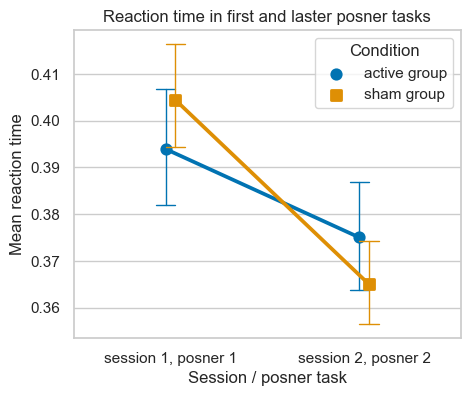

In [465]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')

plt.title('Reaction time in first and laster posner tasks')
plt.xlabel('Session / posner task')
plt.ylabel('Mean reaction time')
plt.legend(title='Condition')
plt.show()

#### ANOVA for reaction time, session and condition

In [476]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
pd.set_option('display.float_format', '{:.4f}'.format)
model = ols('rt ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
pd.reset_option('display.float_format')

                            sum_sq       df       F  PR(>F)
C(group)                    0.0000   1.0000  0.0044  0.9472
C(session_number)           0.1939   1.0000 25.5494  0.0000
C(group):C(session_number)  0.0246   1.0000  3.2438  0.0720
Residual                    7.0723 932.0000     NaN     NaN


## AAI changes?

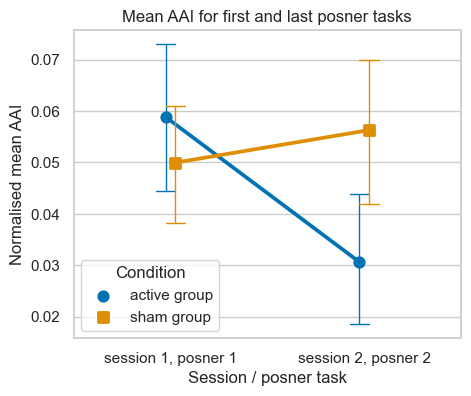

In [466]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='norm_mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('Mean AAI for first and last posner tasks')
plt.xlabel('Session / posner task')
plt.ylabel('Normalised mean AAI')
plt.legend(title='Condition')
plt.show()

#### ANOVA for mean AAI (normalised), session and condition

In [459]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
# pd.set_option('display.float_format', '{:.3f}'.format)
model = ols('norm_mean_aai ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# pd.reset_option('display.float_format')

                              sum_sq     df         F    PR(>F)
C(group)                    0.015563    1.0  1.492175  0.222188
C(session_number)           0.031454    1.0  3.015733  0.082791
C(group):C(session_number)  0.069567    1.0  6.669878  0.009957
Residual                    9.720728  932.0       NaN       NaN


### Baseline changes in AAI

In [468]:
# Selecting columns of interest
df_base = df[['session_number', 
             'session_type', 
             'participant_number', 
             'task', 
             'mean_aai',
             'median_aai',
             'section']]

# # Keep only eyes closed baseline tasks
df_base = df_base.drop(df_base[df_base['task'] == 'posner0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'posner1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback2'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback3'].index)
df_base = df_base.drop(df_base[df_base.section == 'baseline_eo-0'].index)

assert df_base.task.unique()[0]=='baseline0'
assert df_base.task.unique()[1]=='baseline1'
assert len(df_base.task.unique())==2

# df_base = df_base.dropna()

# Just look at session 1 posner a versus session 2 posner b
df_base = df_base.drop(df_base[(df_base['session_number'] == 'ses-01') & (df_base['task'] == 'baseline1') |
                (df_base['session_number'] == 'ses-02') & (df_base['task'] == 'baseline0')].index)
# Double check
assert all(df_base.loc[df_base['session_number'] == 'ses-01', 'task'] == 'baseline0')
assert all(df_base.loc[df_base['session_number'] == 'ses-02', 'task'] == 'baseline1')

# Apply the function to each participant
df_base['group'] = df_base.groupby('participant_number')['session_type'].transform(set_group)

# Rename session_number values for plotting
df_base['session_number'] = df_base['session_number'].replace({'ses-01': 'first baseline', 'ses-02': 'last baseline'})

df_base.head(10)

,session_number,session_type,participant_number,task,mean_aai,median_aai,section,group
1,first baseline,an-at,sub-00,baseline0,-0.118236,-0.118160,baseline_ec-0,active group
219,last baseline,an-at,sub-00,baseline1,-0.143300,-0.157677,baseline_ec-0,active group
433,first baseline,an-at,sub-01,baseline0,0.018763,0.021622,baseline_ec-0,sham group
651,last baseline,sn-at,sub-01,baseline1,-0.001421,-0.000868,baseline_ec-0,sham group
865,first baseline,an-at,sub-02,baseline0,-0.110010,-0.120019,baseline_ec-0,sham group
1081,last baseline,sn-at,sub-02,baseline1,-0.081449,-0.073982,baseline_ec-0,sham group
1295,first baseline,an-at,sub-03,baseline0,-0.142064,-0.147648,baseline_ec-0,active group
1513,last baseline,an-at,sub-03,baseline1,-0.097704,-0.108069,baseline_ec-0,active group
1727,first baseline,an-at,sub-04,baseline0,-0.121281,-0.124691,baseline_ec-0,sham group
1942,last baseline,sn-at,sub-04,baseline1,-0.118966,-0.114777,baseline_ec-0,sham group


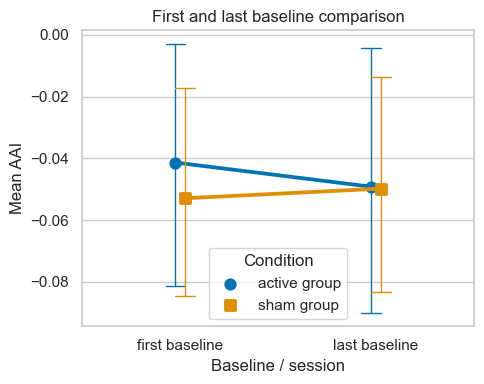

In [469]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='mean_aai', hue='group', data=df_base, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('First and last baseline comparison')
plt.xlabel('Baseline / session')
plt.ylabel('Mean AAI')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

## Neurofeedback time series

Neurofeedback data tidy:

In [470]:
# Selecting columns of interest
df_nfb = df[['session_number', 
             'session_type', 
             'participant_number', 
             'task', 
             'median_aai', 
             'norm_mean_aai', 
             'mean_aai']]


# Keep only posner tasks
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'baseline0'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'baseline1'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'posner0'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'posner1'].index)
assert df_nfb.task.unique()[0]=='neurofeedback0'
assert df_nfb.task.unique()[1]=='neurofeedback1'
assert df_nfb.task.unique()[2]=='neurofeedback2'
assert df_nfb.task.unique()[3]=='neurofeedback3'
assert len(df_nfb.task.unique())==4

# Apply the function to each participant
df_nfb['group'] = df_nfb.groupby('participant_number')['session_type'].transform(set_group)

df_nfb['nfb_task'] = (df_nfb.groupby(['participant_number', 'session_number']).cumcount() + 1).astype(str)

# Rename session_number values for plotting
df_nfb['group'] = df_nfb['group'].replace({'active': 'active group', 'sham': 'sham group'})

# Inspect m_00
df_nfb[df_nfb.participant_number == 'sub-00' ]
df_nfb

,session_number,session_type,participant_number,task,median_aai,norm_mean_aai,mean_aai,group,nfb_task
204,ses-01,an-at,sub-00,neurofeedback0,-0.009669,0.112606,-0.005629,active group,1
205,ses-01,an-at,sub-00,neurofeedback0,0.037820,0.158020,0.039785,active group,2
206,ses-01,an-at,sub-00,neurofeedback0,0.057499,0.178433,0.060197,active group,3
207,ses-01,an-at,sub-00,neurofeedback1,0.033440,0.151722,0.033486,active group,4
208,ses-01,an-at,sub-00,neurofeedback1,0.015562,0.146497,0.028261,active group,5
...,...,...,...,...,...,...,...,...,...
8581,ses-02,an-at,sub-20,neurofeedback2,-0.056513,0.076491,-0.053009,active group,8
8582,ses-02,an-at,sub-20,neurofeedback2,-0.082383,0.062405,-0.067095,active group,9
8583,ses-02,an-at,sub-20,neurofeedback3,0.017803,0.148681,0.019181,active group,10
8584,ses-02,an-at,sub-20,neurofeedback3,-0.023808,0.107106,-0.022394,active group,11


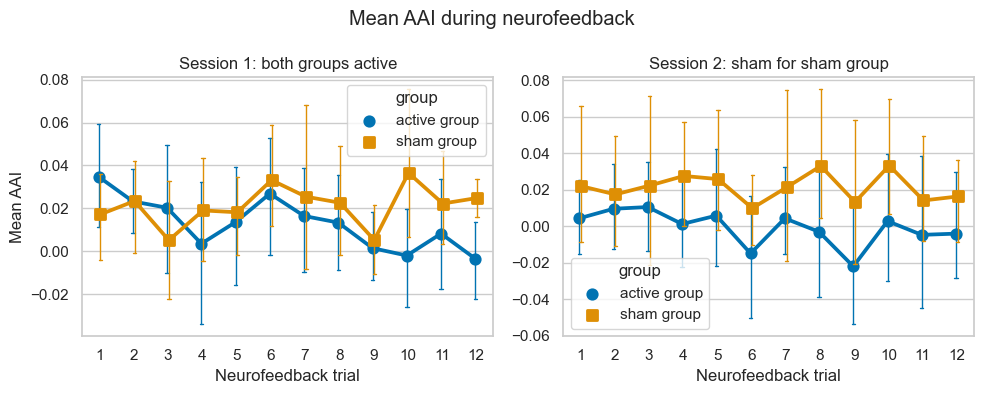

In [471]:
# Session dataframe split
df_nfb_s1 = df_nfb[df_nfb.session_number=='ses-01']
df_nfb_s2 = df_nfb[df_nfb.session_number=='ses-02']
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plots
sns.pointplot(x='nfb_task', y='mean_aai', hue='group', data=df_nfb_s1, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind', ax=axes[0])
sns.pointplot(x='nfb_task', y='mean_aai', hue='group', data=df_nfb_s2, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind', ax=axes[1])
# Y axis limits
# axes[0].set_ylim(-0.01, 0.15)
# axes[1].set_ylim(-0.01, 0.15)
# Titles and labels
fig.suptitle("Mean AAI during neurofeedback")
axes[0].set_title('Session 1: both groups active')
axes[1].set_title('Session 2: sham for sham group')
axes[0].set_ylabel('Mean AAI')
axes[1].set_ylabel('')
axes[0].set_xlabel('Neurofeedback trial')
axes[1].set_xlabel('Neurofeedback trial')
# Layout and show
plt.tight_layout()
plt.show()

# All plots together

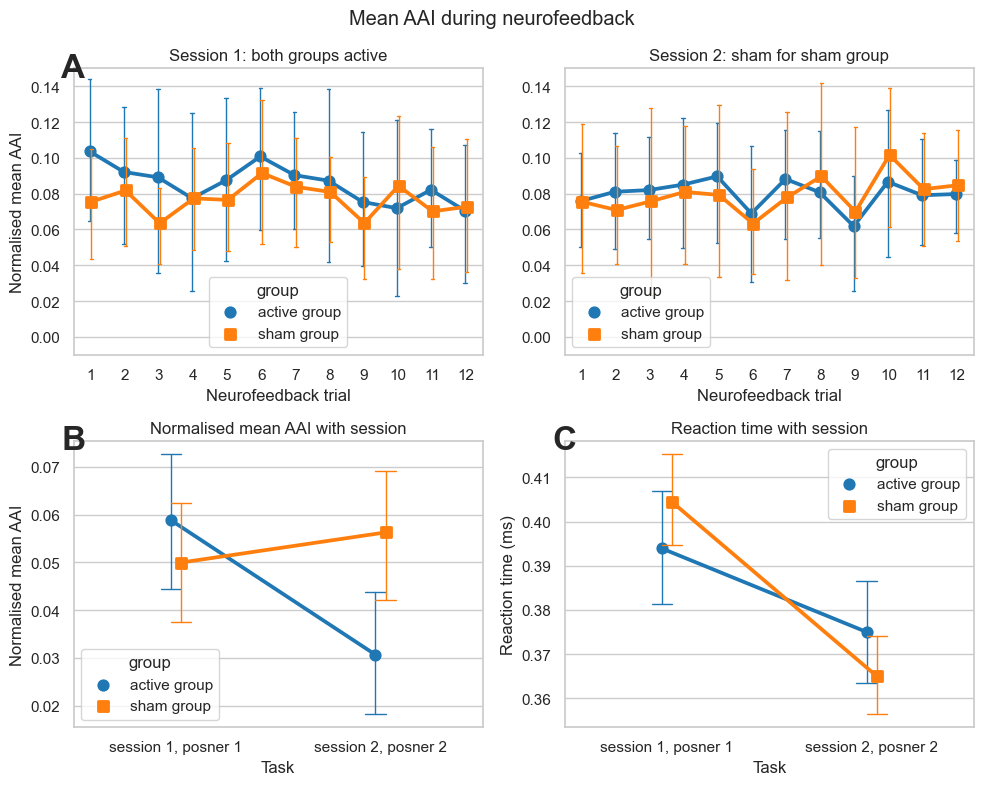

In [472]:
# Session dataframe split
df_nfb_s1 = df_nfb[df_nfb.session_number=='ses-01']
df_nfb_s2 = df_nfb[df_nfb.session_number=='ses-02']
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Plots
sns.pointplot(x='nfb_task', y='norm_mean_aai', hue='group', data=df_nfb_s1, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[0,0])
sns.pointplot(x='nfb_task', y='norm_mean_aai', hue='group', data=df_nfb_s2, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[0,1])
sns.pointplot(x='session_number', y='norm_mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[1,0])
sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,1])

# Y axis limits
axes[0,0].set_ylim(-0.01, 0.15)
axes[0,1].set_ylim(-0.01, 0.15)
# Titles and labels
fig.suptitle("Mean AAI during neurofeedback")
axes[0,0].set_title('Session 1: both groups active')
axes[0,1].set_title('Session 2: sham for sham group')
axes[1,0].set_title('Normalised mean AAI with session')
axes[1,1].set_title('Reaction time with session')
axes[1,0].set_ylabel('Normalised mean AAI')
axes[1,1].set_ylabel('Reaction time (ms)')
axes[0,0].set_ylabel('Normalised mean AAI')
axes[0,1].set_ylabel('')
axes[0,0].set_xlabel('Neurofeedback trial')
axes[0,1].set_xlabel('Neurofeedback trial')
axes[1,0].set_xlabel('Task')
axes[1,1].set_xlabel('Task')

# Annotate
axes[0,0].text(0, 1, 'A', fontsize=24, fontweight='bold', ha='center', va='center', transform=axes[0,0].transAxes)
axes[1,0].text(0, 1, 'B', fontsize=24, fontweight='bold', ha='center', va='center', transform=axes[1,0].transAxes)
axes[1,1].text(0, 1, 'C', fontsize=24, fontweight='bold', ha='center', va='center', transform=axes[1,1].transAxes)

# Layout and show
plt.tight_layout()
plt.show()

# Sanity checking graph values

In [281]:
len(df_nfb_s1[df_nfb_s1.group=='active group'])/12
len(df_nfb_s1[df_nfb_s1.group=='sham group'])/12

df_nfb_s1.participant_number.nunique()

18

In [435]:
tmp = df_nfb_s1[df_nfb_s1.group=='sham group']
tmp = tmp[tmp.nfb_task=='11']
tmp.norm_mean_aai.mean()

0.07013447433961355

In [475]:
tmp = df_nfb_s2[df_nfb_s2.group=='active group']
tmp = tmp[tmp.nfb_task=='5']
tmp.norm_mean_aai.mean()

0.08968271719569759